# はじめに

運営の皆様、新しいコンペの開催ありがとうございます。自然言語処理に挑戦したことが無いのでコンペに参加しながら勉強したいと思います。

上述の通り自然言語処理は初めてですが、ネット上の情報を寄せ集めてひとまず自分の中でBaselintと呼べるものができたので、今朝までの私と同じような「自然言語処理って何からすれば良いの？」という方の参考になれば幸いです。

また、付け焼刃の知識ですので、**間違った知識やよろしくない処理が含まれていると思います。不慣れな方は信じすぎず**、詳しい方はコメントで教えて頂けると大変幸いです。

# 参考にしたサイト

Baseline作成に当たり、以下のサイトを参考にしました。特にkaggleの方はまだまだ読み切っていませんが、当コンペでも役立つ情報が多そうです。

[Kaggle:SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset/notebooks)  
[Qiita:機械学習 〜 迷惑メール分類（ナイーブベイズ分類器） 〜](https://qiita.com/fujin/items/50fe0e0227ef8457a473)

# データとライブラリのインポート

In [48]:
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from bs4 import BeautifulSoup
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS, WordCloud

In [49]:
df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [50]:
df.head()

,id,contents,y
0,1,Subject: re : fw : willis phillips\r\ni just s...,0
1,2,Subject: re : factor loadings for primary curv...,0
2,3,Subject: re : meridian phone for kate symes\r\...,0
3,4,"Subject: re : october wellhead\r\nvance ,\r\nd...",0
4,5,Subject: california 6 / 13\r\nexecutive summar...,0


# 前処理

## stopwordsの定義更新
stopwordsとは、日本語で言えば「は」、「です」など、英語で言えば「a」、「is」などの**出現頻度が高いにも関わらず特別な意味を持たない単語**のことで、こういった単語を削除することで認識精度を向上させます。  
nltkライブラリに基本的なものは格納されていますが、こちらは要するに単なるlistなので、自分でstopwordsを追加することもできます。  
以下では、`string.punctuation`で取得できる記号と、rawデータを見て無駄そうだった"Subject"も加えています。

以下の処理の際、私の環境（Anaconda上のjupyter notebook）ですとpip installできていたと思ってもエラーが起きました。
Anacondaでうまく動かないときは以下もご参照ください。  
https://stackoverflow.com/questions/48385829/how-to-install-stop-words-package-for-anaconda

In [10]:
stop = set(stopwords.words("english"))

# string.punctuation = ['!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
punctuation = list(string.punctuation)

# 手動で追加
org_stop = ["Subject"]

# stopwordsの定義更新
add_stop = punctuation + org_stop
stop.update(add_stop)

## 前処理の適用
stopwordsの削除の他、URLの削除などを行います。

In [52]:
# htmlの分割
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# []で囲まれた文章の削除（脚注、linkなど）
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# URLの削除
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# stopwordsの削除
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)

# ↑の関数をまとめて適用する関数
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# ↑の関数の適用
df['contents']=df['contents'].apply(denoise_text)

# EDA

## targetの分布の確認

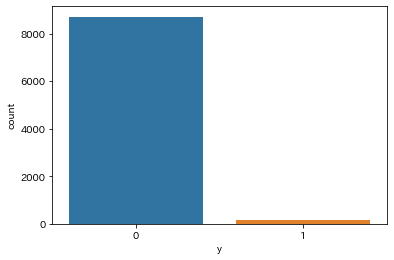

In [51]:
sns.countplot(df["y"])

ほとんどが非スパムで、非常に不均衡なデータです

## spamと非spamに分けてWordCloudを確認
WordColudは「実装したことは無いけど見たことはある」人も多いのではないでしょうか。出現頻度が高い単語ほど大きく、そうでない単語ほど小さく表示し、直感的にどういった単語が多い文章か分かる様になってます。

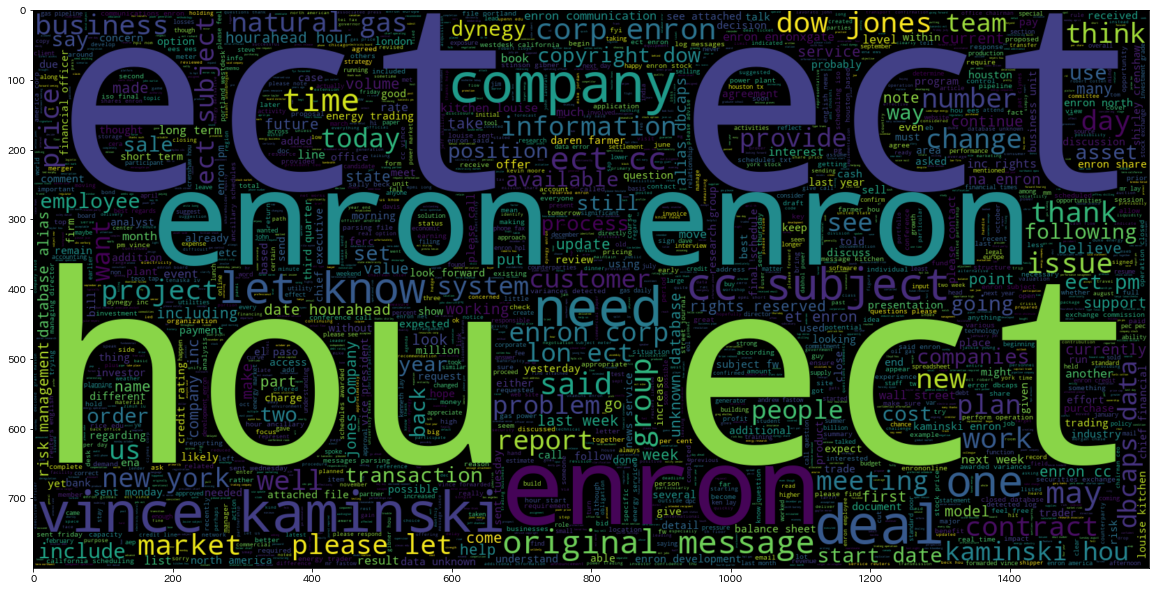

In [53]:
# 非spam
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.y == 0].contents))
plt.imshow(wc, interpolation="bilinear")

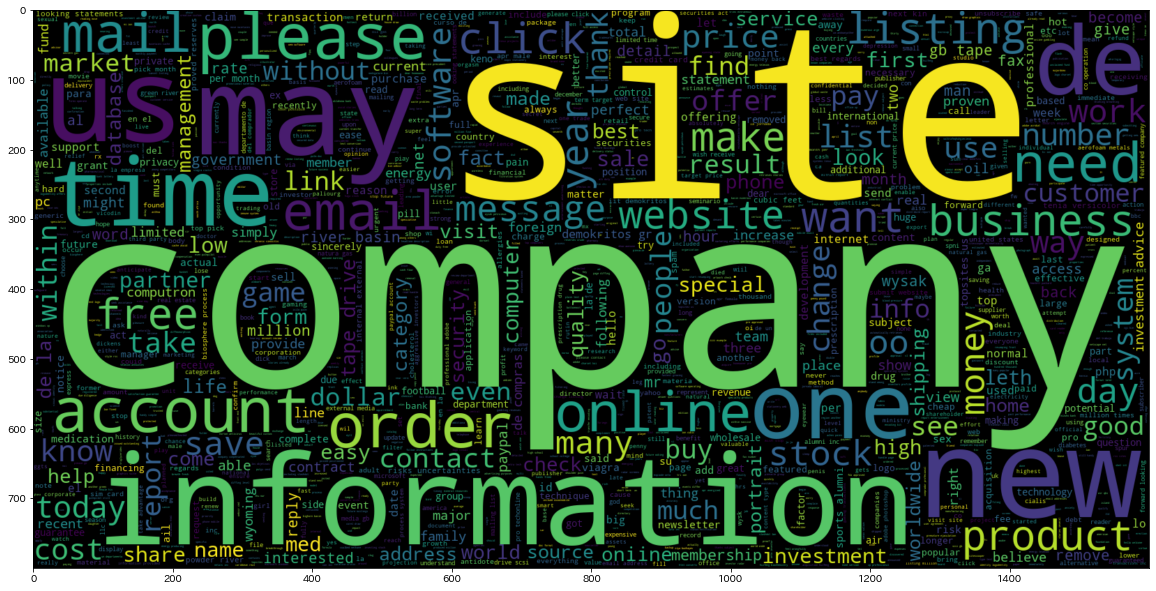

In [54]:
# spam
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.y == 1].contents))
plt.imshow(wc, interpolation="bilinear")

特に非spamの方は固有名詞？と思われる謎の単語が多そうです。testデータ次第かと思いますが、こういった単語もstopwordsに指定して削除することで精度が向上できるかも知れません。  
spamの方は何か買わせようとしている様子が伺えます。

## 文章の長さがspamか否かに関係がありそうか

In [55]:
df["length"] = df["contents"].apply(len)
df.head()

,id,contents,y,length
0,1,fw willis phillips spoke lavo said thing plann...,0,258
1,2,factor loadings primary curves tanya went comp...,0,1007
2,3,meridian phone kate symes bill done mid aftern...,0,254
3,4,october wellhead vance deal created entered si...,0,365
4,5,california executive summary cpuc rules socal ...,0,2130


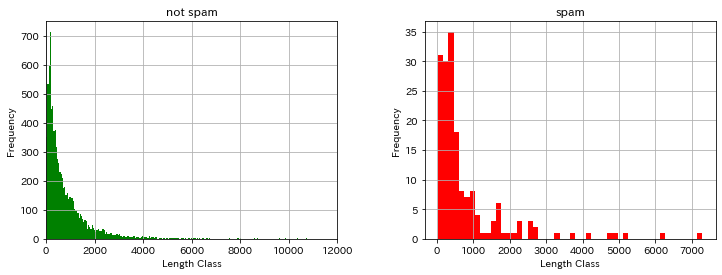

In [56]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

df[df["y"]==0].hist(column="length", bins=2500, ax=ax[0], color = "green")
ax[0].set(xlabel = "Length Class", ylabel = "Frequency", title = "not spam")
ax[0].set_xlim([0,12000])

df[df["y"]==1].hist(column="length", bins=50, ax=ax[1], color = "red")
ax[1].set(xlabel = "Length Class", ylabel = "Frequency", title = "spam")

plt.show()

In [57]:
# 文章の長さの差を数値でも確認
df.groupby("y")["length"].mean()

y
0    1075.788331
1     811.578947
Name: length, dtype: float64

spamの方が文字数は少ない？が分布はそう変わらない様に見えます

## 単語の多さがspamか否かに関係がありそうか

In [58]:
df["words"] = df["contents"].str.split().map(lambda x: len(x))
df.head()

,id,contents,y,length,words
0,1,fw willis phillips spoke lavo said thing plann...,0,258,41
1,2,factor loadings primary curves tanya went comp...,0,1007,153
2,3,meridian phone kate symes bill done mid aftern...,0,254,39
3,4,october wellhead vance deal created entered si...,0,365,58
4,5,california executive summary cpuc rules socal ...,0,2130,286


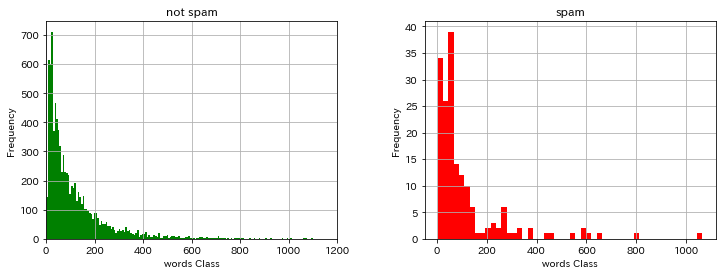

In [59]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

df[df["y"]==0].hist(column="words", bins=2500, ax=ax[0], color = "green")
ax[0].set(xlabel = "words Class", ylabel = "Frequency", title = "not spam")
ax[0].set_xlim([0,1200])

df[df["y"]==1].hist(column="words", bins=50, ax=ax[1], color = "red")
ax[1].set(xlabel = "words Class", ylabel = "Frequency", title = "spam")

plt.show()

In [60]:
# 単語の多さの差を数値でも確認
df.groupby("y")["words"].mean()

y
0    153.408407
1    113.181287
Name: words, dtype: float64

こちらもlengthと同様ですね

# 訓練・予測

## 分類器について
参考サイトをまねて、scikit-learnのナイーブベイズ分類器を使用しています。BernoulliNBとMultinomialNBが候補になりそうですが、ここでは単純に精度が良さそうだったMultinomialNBを使用しています。「二値分類はBernoulliNBを使う」といった情報や、「（BoW変換した後のような）スパースデータにはMultinomialNBが良い」などいった情報があり、まだどちらを使うべきなのか分かっていません。。

その他、ニューラルネットワーク系統（LSTMなど）も候補になりそうなので今後学びたいと思います。

## バリデーションについて
極端な不均衡データかつtestはy==1が半分以上ということからか、`train_test_split()`でランダムに分割してしまうと全く精度が出なかったため、RandomUnderSamplerでアンダーサンプリングして正誤の数を同じにしています。サンプリングのrandom_stateをfor文で変えながら学習&予測して最終的に多数決で予測結果を決めていますが、訓練データに含まれるy==1のデータは毎回同じなので、素人ながら問題があると思っています。stratified k-foldも違う気がしますし、バリデーションはどの様に行うのが良いのでしょうか。。  
また、検証データはrandom_stateを訓練データと変えて取得しているのですが、こちらに含まれるy==1のデータは訓練データと同じものなので、更に問題が大きいです…

In [41]:
# trainデータを分割
X = pd.DataFrame(df['contents'])
y = pd.DataFrame(df['y'])

In [62]:
seed = [i for i in range(5)]
preds = []

for i in seed:
    # アンダーサンプリングしながら訓練用データの作成
    sampler = RandomUnderSampler(random_state=i)
    X_resampled, y_resampled = sampler.fit_resample(X,y)
    
    # 検証用データの作成（random_stateを変えて取得）
    sampler = RandomUnderSampler(random_state=i+10)
    X_val, y_val = sampler.fit_resample(X,y)
    
    # 単語の出現回数取得
    vec_count = CountVectorizer(min_df=3)
    vec_count.fit(X_resampled['contents'])

    # 単語の種類の表示
    print('word size: ', len(vec_count.vocabulary_))
    # 先頭５件の単語を表示
    print('word content: ', dict(list(vec_count.vocabulary_.items())[0:5]))
    
    # 訓練データと検証データをベクトル化
    X_resampled_vec = vec_count.transform(X_resampled['contents'])
    X_val_vec = vec_count.transform(X_val["contents"])
    
    # ベルヌーイモデルで学習
    model = MultinomialNB()
    model.fit(X_resampled_vec, y_resampled['y'])
    
    # F1スコアのprint
    print("val_F1-score",f1_score(model.predict(X_val_vec),y_val))
    print("------------------------------------------------------------------------------------------------------------------")
    
    # testデータをベクトル化
    df_data = pd.DataFrame(test, columns=['contents'])
    input_vec = vec_count.transform(df_data['contents'])

    # testの予測→seed毎に空のリストに格納
    pred = model.predict(input_vec)
    preds.append(pred)

word size:  2403
word content:  {'request': 1793, 'submitted': 2084, 'access': 8, 'manfred': 1248, 'enron': 669}
val_F1-score 0.9602272727272728
------------------------------------------------------------------------------------------------------------------
word size:  2121
word content:  {'denver': 470, 'meeting': 1140, 'vince': 2039, 'went': 2069, 'interesting': 920}
val_F1-score 0.9710982658959537
------------------------------------------------------------------------------------------------------------------
word size:  2780
word content:  {'planning': 1826, 'energy': 803, 'finance': 956, 'class': 428, 'presentation': 1880}
val_F1-score 0.9523809523809523
------------------------------------------------------------------------------------------------------------------
word size:  2623
word content:  {'start': 2247, 'date': 575, 'hourahead': 1075, 'hour': 1074, 'ancillary': 111}
val_F1-score 0.9659090909090909
----------------------------------------------------------------------

## 予測結果

In [45]:
# 予測結果を多数決
prediction = stats.mode(preds)[0]

# spam判定数を確認
# test全体で17000とのこと
prediction.sum()

16607

In [46]:
# 提出用DaraFrameの作成
sub = pd.DataFrame(test["id"])
sub["y"] = prediction.T

In [47]:
# 予測ファイルの作成
# LB:0.9688243693
sub.to_csv("submission.csv",index=False)